# Import all Packages

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Data Preparation
1. We will be using the model `vit_base_patch16_224`
  * This means all image need to be reshaped to (224,224)
2. In training, we are using data augmentation process: `RandomHorizontalFlip`. 
  * It is optional step
  *  It randomly flips an input image horizontally
  * It  artificially increase the size and diversity of the training dataset
3. We also normalizes the image `transforms.Normalize`
  * This will reduce the scale of image
  * It helps on Faster convergence, better generalization, and numercial stability


In [4]:
# Please download the images from `https://www.kaggle.com/datasets/jr2ngb/cataractdataset` and place in your machine's directory
DATA_DIR = "dataset/"
CLASSES = ["1_normal", "2_cataract", "2_glaucoma", "3_retina_disease"]

data = []
for class_idx, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        data.append([img_path, class_idx])

df = pd.DataFrame(data, columns=["image_path", "label"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CataractDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CataractDataset(train_df["image_path"].values, train_df["label"].values, transform=train_transforms)
test_dataset = CataractDataset(test_df["image_path"].values, test_df["label"].values, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)



# Let's review our dataloader
1. We are just viewing the image from train_dataloader
2. There is one very important step:
  * matplotlib need the image in [H, W, C]; where dataloader has image of shape [C, H,W]
  * Thus, before plotting we are transposing so that the data is suitable for viewing for matplotlib

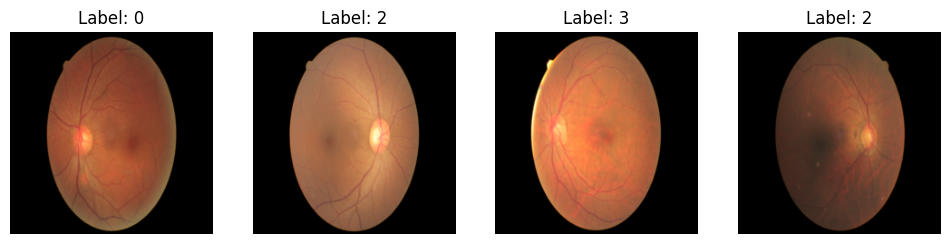

In [6]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to unnormalize and convert a tensor image to numpy array
def imshow(img_tensor):
    img = img_tensor.numpy()
    # transposing
    img = np.transpose(img, (1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Display the images and their labels
fig, axes = plt.subplots(1, len(images), figsize=(12, 12))

for idx, (image, label) in enumerate(zip(images, labels)):
    axes[idx].imshow(imshow(image))
    axes[idx].set_title(f"Label: {label.item()}")
    axes[idx].axis("off")

plt.show()


# Declare the model
1. We are using the pre-trained model from timm
2. If the image is color, 
  * in_chans=3;
3. if image is graysclae, 
  * in_chans=3=1
4. We need to declare, how many classes we have in out dataset: 
  * For our case, it was 4.
  * num_classes=4
5. `pretrained=True`
  * We are mentioning that we want weight of pre-trained model. If you want to train from scratch, you could just mention 
    * pretrained=False

In [8]:
import timm
model = timm.create_model("vit_base_patch16_224", in_chans=3, num_classes=4, pretrained=True)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Declare the train and test loop
1. In the below code: I am converting output and target into 'cpu'. Somehow my M1 chip is producing the problem. You may not encounter the problem. Thus, this is totally optional step.

In [12]:
def train(model, device, train_loader, optimizer, criterion, epoch, accelerator):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        accelerator.backward(loss)
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}")

from sklearn.metrics import confusion_matrix, recall_score, precision_score

def test(model, device, test_loader, criterion, accelerator):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            output_cpu = output.to('cpu')
            target_cpu=target.to('cpu')
            pred = output_cpu.argmax(dim=1, keepdim=True)
            correct += pred.eq(target_cpu.view_as(pred)).sum().item()
            
            all_preds.extend(pred.flatten().tolist())
            all_targets.extend(target.flatten().tolist())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Calculate confusion matrix, sensitivity (recall), and specificity
    cm = confusion_matrix(all_targets, all_preds)
    sensitivity = recall_score(all_targets, all_preds, average=None)
    #specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)
    # Calculate specificity safely
    column_sums = cm.sum(axis=0)
    specificity = np.divide(column_sums - cm.diagonal(), column_sums, 
                           where=column_sums != 0, out=np.zeros_like(column_sums, dtype=float))
    
    for i, (sens, spec) in enumerate(zip(sensitivity, specificity)):
        print(f"Class {i}: Sensitivity (Recall): {sens:.4f}, Specificity: {spec:.4f}")



In [13]:
from accelerate import Accelerator
from torch.optim import Adam

accelerator = Accelerator()
device = accelerator.device
learning_rate = 1e-4

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
model, optimizer, criterion = accelerator.prepare(model, optimizer, criterion)





In [14]:


num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, accelerator)
    test(model, device, test_loader, criterion, accelerator)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:37<00:00,  3.24it/s]


Epoch: 1, Loss: 1.2177
Test Loss: 1.0938, Accuracy: 57.02%
Class 0: Sensitivity (Recall): 1.0000, Specificity: 0.4602
Class 1: Sensitivity (Recall): 0.4000, Specificity: 0.0000
Class 2: Sensitivity (Recall): 0.0000, Specificity: 0.0000
Class 3: Sensitivity (Recall): 0.0000, Specificity: 0.0000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:37<00:00,  3.17it/s]


Epoch: 2, Loss: 1.1303


KeyboardInterrupt: 

# Analysis:
1. The loss is decreasing. We need more epoch.

In [ ]:
#